# Assignment 6
#### Problem 2

Jérémie Engler and Laure Toullier

07.12.2023

Aim : analysis of a cantilever beam-column element subjected to a tip force

In [21]:
#imports

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

np.set_printoptions(precision=6, suppress=True, linewidth=150)

Params = plt.rcParams
Params['figure.figsize'] = (14, 7) 

In [22]:
#Data

a = 200 #mm
b = 200 #mm
L = 2000 #mm (uniform XS)

nf = 10 #number of fibers in the XS
ng=5

E0 = 200000 #MPa
E = 200000*np.ones((ng,nf)) #MPa (elastic material)
stress_fibers = np.ones((ng, nf)) #initial stress in each fiber

Step 1 : Implement and validate a displacement based fiber beam-column element

In [23]:
#computation of tangent section stiffness matrix and section resisting force

def ks(nf):
    yk=np.zeros((nf))     #array for each the coordinate of each centroïd of each fiber
    lk=np.zeros((nf,2))
    ksi=np.zeros((2,ng*2))   #tangent section stiffness matrix
    ksii=np.zeros((2,2))
    for j in range(ng):
        for i in range(nf):
            yk[i]=-b/2+b/(2*nf)+b/nf*((i+1)-1) #centroïd of each fiber
            lki=np.array([[1,yk[i]]])
            lk[i]=lki
            ksi[:,2*j:2*j+2]+=np.transpose(lki)@lki*E[j,i]*(a*b/nf)
        
    return ksi

#note: as the XS is constant, ks is constant along the cantilever


def fs(nf, stress_fibers):
    yk=np.zeros((nf))     #array for each the coordinate of each centroïd of each fiber
    lk=np.zeros((nf,2))
    fs=np.zeros((2,ng))   #section resisting force

    for j in range(ng):
        for i in range(nf):
            yk[i]=-b/2+b/(2*nf)+b/nf*((i+1)-1) #centroïd of each fiber
            lki=np.array([[1,yk[i]]])
            lk[i]=lki
            fs[:,j] += + (np.transpose(lki)*stress_fibers[j, i]*(a*b/nf)).reshape(fs[:,j].shape)

    return fs


#note: initially, the stresses are constant in the cantilever, therefore fs is constant

The numerical integration used to obtain a numerical estimate of the integral is Gauss-Lobato, with 5 integration points. The conditions that satisfy all error partial derivatives for 5 integration points are:

    w1=w5=1/10 and r1=1, r5=-1

    w2=w4=49/90 and r2=-sqrt(21)/7, r4=sqrt(21)/7 
    
    w3=32/45 and r3=0

In [24]:
#computation of the stiffness matrix

w=np.array([0.1,49/90,32/45,49/90,0.1])
r=np.array([-1,-np.sqrt(21)/7,0,np.sqrt(21)/7,1])

def Ke_Qe(L,r,w,k_s,f_s):
    
    Ke=np.zeros((6,6))
    Qfv=np.zeros((6,1))

    for i in range(len(w)) :
        xi=L/2*r[i]+L/2

        B=np.array([[-1/L, 0,0,1/L,0,0],
                    [0,(12*xi/L**3-6/L**2), (6*xi/L**2-4/L), 0,(-12*xi/L**3+6/L**2), (6*xi/L**2-2/L)]])
        
        kb=(B.T@k_s[:,2*i:2*i+2])@B
        Ke+=L/2*w[i]*kb

        qb=B.T@f_s[:,i]
        Qfv+=(L/2*qb*w[i]).reshape(Qfv.shape)
    
    return Ke, Qfv




In [25]:
k_s=ks(nf)
f_s=fs(nf, stress_fibers)
K_e,Q_e=Ke_Qe(L,r,w,k_s,f_s)


In [26]:
print(f"k_s={k_s}")
print(f"f_s={f_s}")
print(f"The element resisting force vector is ")
print(Q_e)
print("The tangent element stiffness matrix of a displacement based fiber BC elemnt is:")
print(K_e)

k_s=[[8.00e+09 0.00e+00 8.00e+09 0.00e+00 8.00e+09 0.00e+00 8.00e+09 0.00e+00 8.00e+09 0.00e+00]
 [0.00e+00 2.64e+13 0.00e+00 2.64e+13 0.00e+00 2.64e+13 0.00e+00 2.64e+13 0.00e+00 2.64e+13]]
f_s=[[40000. 40000. 40000. 40000. 40000.]
 [    0.     0.     0.     0.     0.]]
The element resisting force vector is 
[[-40000.]
 [     0.]
 [     0.]
 [ 40000.]
 [     0.]
 [     0.]]
The tangent element stiffness matrix of a displacement based fiber BC elemnt is:
[[ 4.00e+06  0.00e+00  0.00e+00 -4.00e+06  0.00e+00  0.00e+00]
 [ 0.00e+00  3.96e+04  3.96e+07  0.00e+00 -3.96e+04  3.96e+07]
 [ 0.00e+00  3.96e+07  5.28e+10  0.00e+00 -3.96e+07  2.64e+10]
 [-4.00e+06  0.00e+00  0.00e+00  4.00e+06  0.00e+00  0.00e+00]
 [ 0.00e+00 -3.96e+04 -3.96e+07  0.00e+00  3.96e+04 -3.96e+07]
 [ 0.00e+00  3.96e+07  2.64e+10  0.00e+00 -3.96e+07  5.28e+10]]


In [27]:
#classical stiffness matrix (from week 7, slide 19)

def stiffness_elastic_beam (E0,a,b,L):

    K=np.zeros((6,6))

    I=a*b**3/12
    A=a*b
    
    K[0,0]=E0*A/L
    K[0,3]=-E0*A/L
    K[3,0]=-E0*A/L
    K[3,3]=E0*A/L

    K[1,1]=K[4,4]=E0*I*12/L**3
    K[1,2]=K[2,1]=E0*I*6/L**2
    K[2,2]=K[5,5]=E0*I*4/L
    K[5,4]=K[4,5]=-6*E0*I/L**2

    K[1,4]=K[4,1]=-E0*I*12/L**3
    K[1,5]=K[5,1]=E0*I*6/L**2
    K[2,4]=K[4,2]=-E0*I*6/L**2
    K[2,5]=K[5,2]=E0*I*2/L

    return K

K_classic=stiffness_elastic_beam (E0,a,b,L)
print(f"K_classic={K_classic}")


K_classic=[[ 4.000000e+06  0.000000e+00  0.000000e+00 -4.000000e+06  0.000000e+00  0.000000e+00]
 [ 0.000000e+00  4.000000e+04  4.000000e+07  0.000000e+00 -4.000000e+04  4.000000e+07]
 [ 0.000000e+00  4.000000e+07  5.333333e+10  0.000000e+00 -4.000000e+07  2.666667e+10]
 [-4.000000e+06  0.000000e+00  0.000000e+00  4.000000e+06  0.000000e+00  0.000000e+00]
 [ 0.000000e+00 -4.000000e+04 -4.000000e+07  0.000000e+00  4.000000e+04 -4.000000e+07]
 [ 0.000000e+00  4.000000e+07  2.666667e+10  0.000000e+00 -4.000000e+07  5.333333e+10]]


In [28]:
#computation of the error

def error(nf):
    #stress_fibers = np.ones((ng, nf))
    k_s=ks(nf)
    f_s=fs(nf, stress_fibers)
    #print(f"{f_s.shape=}")
    K_e,Q=Ke_Qe(L,r,w,k_s,f_s)
    
    err=np.linalg.norm(K_e-K_classic)/np.linalg.norm(K_classic)*100
    return err

def error_min(err_accept):
    n_iter=20
    n=1
    while error(n)>err_accept and n<n_iter:
        n+=1
    return n


In [29]:
err=error(nf)
print(f"error={err}")
min_num_fibers=error_min(2)
err_min=error(min_num_fibers)
print(f"Minimum number of fibers for error less than 2%={min_num_fibers}")
print(f"For a minimum number of fiber less than 2%, the error is: {err_min}")

error=0.9999999955000101
Minimum number of fibers for error less than 2%=8
For a minimum number of fiber less than 2%, the error is: 1.5624999929687748


Step 2: Conduct a load control analysis with your beam-column element

Aim: create a cantilever model using displacement-based fiber beam-column element.

In [30]:
nf=min_num_fibers #8 according to step 1
E=200000*np.ones((len(r),nf)) #MPa
V_end=450000
q0=np.transpose(np.array([[0,0,0,0,0,0]]))         #displacement (initial)
Q_ext=np.transpose(np.array([[0,0,0,0,V_end,0]]))
dof=np.array([3,4,5]) #index at which the element is free
fixed=np.array([0,1,2]) #index at which the element is fixed
num_incr=30    #number of increments
tol=10**(-8)
max_iter=16
iteration_counter=1
stress_fibers=np.zeros((ng, nf)) #new stress in each fiber for new number of fibers
print(f"{stress_fibers.shape = }")


stress_fibers.shape = (5, 8)


In [31]:
#section deformation

def section_deformation(L,q,r):
    ds=np.zeros((2,len(r)))
    for i in range(len(r)):
        xi=L/2*r[i]+L/2
        B=np.array([[-1/L, 0,0,1/L,0,0],
                    [0,(12*xi/L**3-6/L**2), (6*xi/L**2-4/L), 0,(-12*xi/L**3+6/L**2), (6*xi/L**2-2/L)]]) 
        
        dsi=np.matmul(B,q)
        ds[0,i]=dsi[0]
        ds[1,i]=dsi[1]
    print(f"{ds = }")
    return ds

In [32]:
#displacement increment

def displacement_incr(K_ff,R_f):
    deltaqf=np.linalg.solve(K_ff,R_f)
    delta_q_f=np.zeros((6,1))
    for i in range(3):
        delta_q_f[i+3][0]=deltaqf[i][0]
    
    return delta_q_f

In [33]:
#fiber strain
def fiber_strains(nf,b,ds):
    yk=np.zeros((nf))
    eps=np.zeros((len(r), nf))
    for j in range(len(r)):
        for i in range(nf):
            yk[i]=-b/2+b/(2*nf)+b/nf*((i+1)-1) #centroïd of each fiber
            eps[j,i]=ds[0,j]+ds[1,j]*yk[i]
    print(f"{eps =}")
    return eps


#initialisation
force5=[]
disp5=[]
iteration_counter=[0]
q=q0

k_s=ks(nf)
print(f"{nf, stress_fibers.shape = }")
f_s=fs(nf, stress_fibers)
K_e, Q_e= Ke_Qe(L,r,w,k_s,f_s)
ds=section_deformation(L,q,r)
eps=fiber_strains(nf,b,ds)
print(f"{eps.shape=}")
print(eps)


nf, stress_fibers.shape = (8, (5, 8))
ds = array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])
eps =array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])
eps.shape=(5, 8)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


C:\Users\ltoul\AppData\Local\Temp\ipykernel_16720\2796413056.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ds[0,i]=dsi[0]
C:\Users\ltoul\AppData\Local\Temp\ipykernel_16720\2796413056.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ds[1,i]=dsi[1]


In [34]:
#fiber stresses

def fiber_stresses_elastic(eps,E):
    stresses_fibers=eps*E
    print(f"fiber_stresses_elastic: {stresses_fibers = }")
    return stresses_fibers

In [35]:
#newton raphson method

#initialisation
force5=[]
disp5=[]
iteration_counter=[]
q=q0



k_s=ks(nf)
f_s=fs(nf, stress_fibers)
K_e, Q_e= Ke_Qe(L,r,w,k_s,f_s)
ds=section_deformation(L,q,r)


for j in range(num_incr):
    print(f"%%%%%%%%%%%%%%%%%%%%%%%%%%{j}th increment%%%%%%%%%%%%%%%%%%%%%%%%%%")
       
    iteration_counter.append(j)

    Q_ext_i=(j+1)/num_incr*Q_ext
    print(f"Q_ext_i={Q_ext_i}")

    k_s=ks(nf)
    f_s=fs(nf, stress_fibers)
    K_e, Q_e= Ke_Qe(L,r,w,k_s,f_s)

    R=Q_ext_i-Q_e

    for i in range(max_iter):
        print(f"%%%%%%%%%%%%%%%%%%%%%%%%%{i}th iteration%%%%%%%%%%%%%%%%%%%%%%%%%%")

        K_ff=K_e[3:6,3:6] #we only consider the free DOF from Ke
        R_f=R[3:6,:] #we only consider the free DOF from R

        #displacement
        delta_q_f=displacement_incr(K_ff,R_f)
        q=q+delta_q_f
        print(f"q={q}")

        #section deformation
        ds=section_deformation(L,q,r)

        #strain in each fiber:
        strain= fiber_strains(nf,b,ds)

        #stresses in each fiber
        stress_fibers=fiber_stresses_elastic(strain,E)

        #Element stiffness and element resisting force vector computed with new stresses in fibers
        k_s=ks(nf)
        f_s=fs(nf, stress_fibers)
        K_e, Q_e= Ke_Qe(L,r,w,k_s,f_s)
        print(f"Qe={Q_e}")

        R=Q_ext_i-Q_e
        R[fixed]=0       #the residual is set to 0 at the degree where the element is fixed
        print(f"R={R}")
        norm_R=np.linalg.norm(R)
        print(f"{norm_R=}")
        norm_Qext=np.linalg.norm(Q_ext_i)
        print(f"{norm_Qext=}")

        if norm_R/norm_Qext<tol or i>max_iter:
            force5.append(Q_e[4][0])
            disp5.append(q[4][0])
            break #if the tolerance is reached, we need to go "out of the loop" to go to the newt load iteration

        if norm_R/norm_Qext>tol and i==max_iter-1:
            #print("no convergence")
            raise ValueError("No convergence !")

    

ds = array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])
%%%%%%%%%%%%%%%%%%%%%%%%%%0th increment%%%%%%%%%%%%%%%%%%%%%%%%%%
Q_ext_i=[[    0.]
 [    0.]
 [    0.]
 [    0.]
 [15000.]
 [    0.]]
%%%%%%%%%%%%%%%%%%%%%%%%%0th iteration%%%%%%%%%%%%%%%%%%%%%%%%%%
q=[[0.      ]
 [0.      ]
 [0.      ]
 [0.      ]
 [1.52381 ]
 [0.001143]]
ds = array([[ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.000001,  0.000001,  0.000001,  0.      , -0.      ]])
eps =array([[-0.0001  , -0.000071, -0.000043, -0.000014,  0.000014,  0.000043,  0.000071,  0.0001  ],
       [-0.000083, -0.000059, -0.000035, -0.000012,  0.000012,  0.000035,  0.000059,  0.000083],
       [-0.00005 , -0.000036, -0.000021, -0.000007,  0.000007,  0.000021,  0.000036,  0.00005 ],
       [-0.000017, -0.000012, -0.000007, -0.000002,  0.000002,  0.000007,  0.000012,  0.000017],
       [ 0.      ,  0.      ,  0.      ,  0.      , -0.      , -0.      , -0.      , -0.      ]])
fiber_stresses_elastic: stresses_fib

C:\Users\ltoul\AppData\Local\Temp\ipykernel_16720\2796413056.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ds[0,i]=dsi[0]
C:\Users\ltoul\AppData\Local\Temp\ipykernel_16720\2796413056.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ds[1,i]=dsi[1]


%%%%%%%%%%%%%%%%%%%%%%%%%0th iteration%%%%%%%%%%%%%%%%%%%%%%%%%%
q=[[ 0.      ]
 [ 0.      ]
 [ 0.      ]
 [ 0.      ]
 [19.809524]
 [ 0.014857]]
ds = array([[ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.000015,  0.000012,  0.000007,  0.000003, -0.      ]])
eps =array([[-0.0013  , -0.000929, -0.000557, -0.000186,  0.000186,  0.000557,  0.000929,  0.0013  ],
       [-0.001076, -0.000768, -0.000461, -0.000154,  0.000154,  0.000461,  0.000768,  0.001076],
       [-0.00065 , -0.000464, -0.000279, -0.000093,  0.000093,  0.000279,  0.000464,  0.00065 ],
       [-0.000224, -0.00016 , -0.000096, -0.000032,  0.000032,  0.000096,  0.00016 ,  0.000224],
       [ 0.      ,  0.      ,  0.      ,  0.      , -0.      , -0.      , -0.      , -0.      ]])
fiber_stresses_elastic: stresses_fibers = array([[-260.      , -185.714286, -111.428571,  -37.142857,   37.142857,  111.428571,  185.714286,  260.      ],
       [-215.104977, -153.646412,  -92.187847,  -30.729282,   30.729282,  

In [51]:

def printgraph(x,y,xname,yname,unit1, unit2):
    plt.figure(figsize=(7, 5))
    plt.plot(x,y,'-o', mfc="w")
    
    # Show a straight line
    # plt.axline((x[0], y[0]), (x[1], y[1]))

    plt.title(f'{yname} as a function of {xname}')
    plt.xlabel(f"{xname} [{unit1 or "-"}]")
    plt.ylabel(f"{yname} [{unit2 or "-"}]")

    plt.text(max(x)*0.5, max(y)*0.9, f"$x_{{max}}={max(x):.6e}$\n$y_{{max}} = {max(y):.6e}$")
    
    plt.show()

    return None

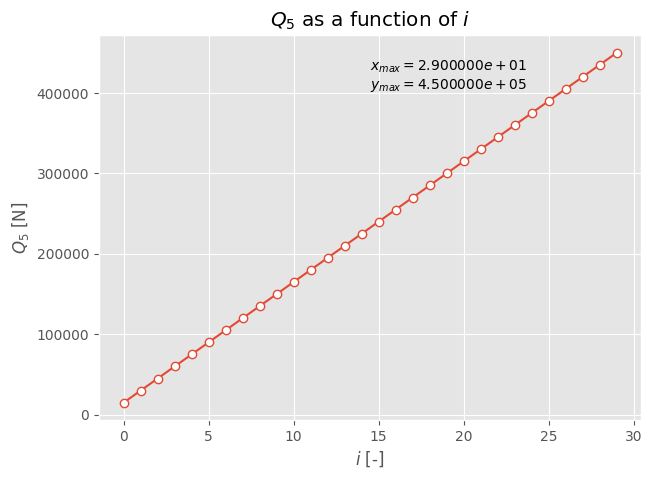

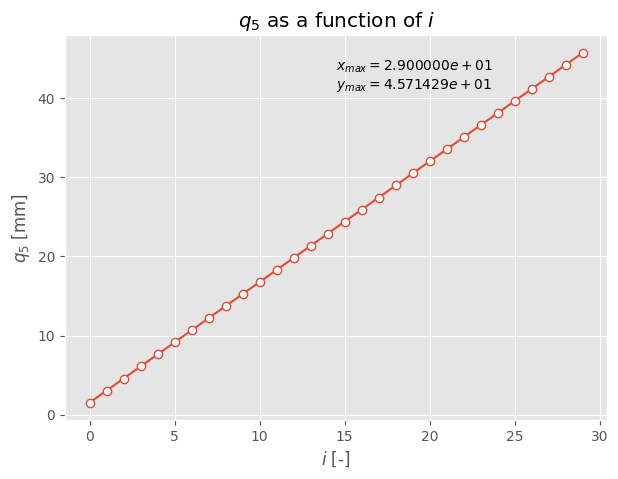

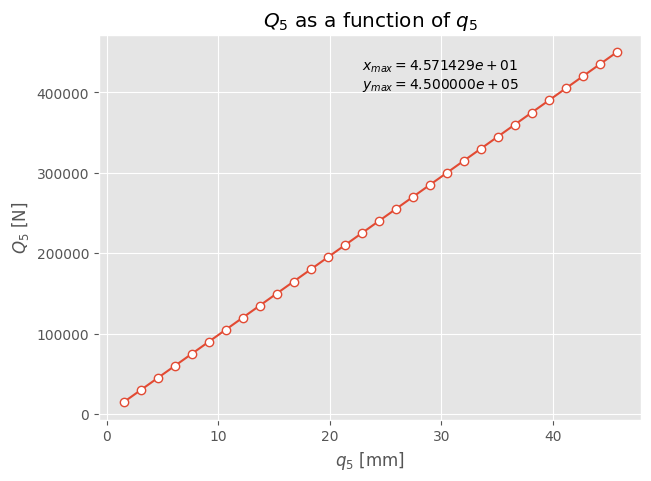

In [37]:
printgraph(iteration_counter,force5,"$i$","$Q_5$","","N")
printgraph(iteration_counter,disp5,"$i$","$q_5$","","mm")
printgraph(disp5,force5,"$q_5$","$Q_5$","mm","N")
 

Step 3: Plasticity: Add an elastic-perfectly-plastic (EPP) material

In [38]:
sigma_y=355 #MPa
Ep=200000*np.ones((len(r), nf)) #MPa

In [41]:
#stress function



def stress_elastic_perfectly_plastic(E, sigma_y,eps):
    eps_y=sigma_y/E0
    sigma=np.zeros((len(r), nf))

    for j in range(len(r)):
        for i in range(nf):
            if np.abs(eps[j,i])<eps_y:
                E[j,i]=E0
                sigma[j,i]=E[j,i]*eps[j,i]
            else:
                alpha=0 #perfectly plastic
                E[j,i]=E0*alpha
                sigma[j,i]=np.sign(eps[j,i])*sigma_y
    
    return sigma

In [42]:
#stress and tangent modulus for each fiber, at each integration point

stress_EPP=stress_elastic_perfectly_plastic(E, sigma_y,strain)
print(f"{stress_EPP=}")

stress_EPP=array([[-355.      , -355.      , -257.142857,  -85.714286,   85.714286,  257.142857,  355.      ,  355.      ],
       [-355.      , -354.568644, -212.741186,  -70.913729,   70.913729,  212.741186,  354.568644,  355.      ],
       [-300.      , -214.285714, -128.571429,  -42.857143,   42.857143,  128.571429,  214.285714,  300.      ],
       [-103.603899,  -74.002785,  -44.401671,  -14.800557,   14.800557,   44.401671,   74.002785,  103.603899],
       [   0.      ,    0.      ,    0.      ,    0.      ,   -0.      ,   -0.      ,   -0.      ,   -0.      ]])


In [43]:
#newton raphson step 3

nf=min_num_fibers #8 according to step 1
V_end=450000
q0=np.transpose(np.array([[0,0,0,0,0,0]]))  #displacement (initial)
Q_ext=np.transpose(np.array([[0,0,0,0,V_end,0]]))
dof=np.array([3,4,5]) #index at which the element is free
fixed=np.array([0,1,2]) #index at which the element is fixed
num_incr=30    #number of increments
tol=10**(-8)
max_iter=16
iteration_counter=1
stress_fibers_3=np.zeros((ng, nf)) #new stress in each fiber for new number of fibers
print(f"{stress_fibers_3.shape = }")

#initialisation
force5_step3=[]
disp5_step3=[]
iteration_counter=[]
q=q0

k_s=ks(nf)
f_s=fs(nf, stress_fibers_3)
K_e, Q_e= Ke_Qe(L,r,w,k_s,f_s)
ds_3=section_deformation(L,q,r)


for j in range(num_incr):
    print(f"%%%%%%%%%%%%%%%%%%%%%%%%%%{j}th increment%%%%%%%%%%%%%%%%%%%%%%%%%%")
       
    iteration_counter.append(j)

    Q_ext_i=(j+1)/num_incr*Q_ext
    print(f"Q_ext_i={Q_ext_i}")

    k_s=ks(nf)
    f_s=fs(nf, stress_fibers_3)
    K_e, Q_e= Ke_Qe(L,r,w,k_s,f_s)

    R=Q_ext_i-Q_e

    for i in range(max_iter):
        print(f"%%%%%%%%%%%%%%%%%%%%%%%%%{i}th iteration%%%%%%%%%%%%%%%%%%%%%%%%%%")

        K_ff=K_e[3:6,3:6] #we only consider the free DOF from Ke
        R_f=R[3:6,:] #we only consider the free DOF from R

        #displacement
        delta_q_f=displacement_incr(K_ff,R_f)
        q=q+delta_q_f
        print(f"q={q}")

        #section deformation
        ds_3=section_deformation(L,q,r)

        #strain in each fiber:
        strain_3= fiber_strains(nf,b,ds_3)

        #stresses in each fiber
        #stress_fibers=fiber_stresses_elastic(strain,E)
        
        stress_fibers_3=stress_elastic_perfectly_plastic(E, sigma_y,strain_3)
        print(f"{stress_fibers_3 = }")

        #Element stiffness and element resisting force vector computed with new stresses in fibers
        k_s=ks(nf)
        f_s=fs(nf, stress_fibers_3)
        K_e, Q_e= Ke_Qe(L,r,w,k_s,f_s)
        print(f"Qe={Q_e}")

        R=Q_ext_i-Q_e
        R[fixed]=0 #the residual is set to 0 at the degree where the element is fixed
        print(f"R={R}")
        norm_R=np.linalg.norm(R)
        print(f"{norm_R=}")
        norm_Qext=np.linalg.norm(Q_ext_i)
        print(f"{norm_Qext=}")

        if norm_R/norm_Qext<tol or i>max_iter:
            force5_step3.append(Q_e[4][0])
            disp5_step3.append(q[4][0])
            break #if the tolerance is reached, we need to go "out of the loop" to go to the newt load iteration

        if norm_R/norm_Qext>tol and i==max_iter-1:
            #print("no convergence")
            raise ValueError("No convergence !")


stress_fibers_3.shape = (5, 8)
ds = array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])
%%%%%%%%%%%%%%%%%%%%%%%%%%0th increment%%%%%%%%%%%%%%%%%%%%%%%%%%
Q_ext_i=[[    0.]
 [    0.]
 [    0.]
 [    0.]
 [15000.]
 [    0.]]
%%%%%%%%%%%%%%%%%%%%%%%%%0th iteration%%%%%%%%%%%%%%%%%%%%%%%%%%
q=[[0.      ]
 [0.      ]
 [0.      ]
 [0.      ]
 [3.022509]
 [0.002002]]
ds = array([[ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.000003,  0.000002,  0.000001, -0.      , -0.000001]])
eps =array([[-0.000222, -0.000158, -0.000095, -0.000032,  0.000032,  0.000095,  0.000158,  0.000222],
       [-0.000175, -0.000125, -0.000075, -0.000025,  0.000025,  0.000075,  0.000125,  0.000175],
       [-0.000088, -0.000063, -0.000038, -0.000013,  0.000013,  0.000038,  0.000063,  0.000088],
       [ 0.      ,  0.      ,  0.      ,  0.      , -0.      , -0.      , -0.      , -0.      ],
       [ 0.000046,  0.000033,  0.00002 ,  0.000007, -0.000007, -0.00002 , -0.000033, -0.000046]])
stres

C:\Users\ltoul\AppData\Local\Temp\ipykernel_16720\2796413056.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ds[0,i]=dsi[0]
C:\Users\ltoul\AppData\Local\Temp\ipykernel_16720\2796413056.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ds[1,i]=dsi[1]


Qe=[[-1.520675e-10]
 [-3.450000e+05]
 [-6.900000e+08]
 [ 1.520675e-10]
 [ 3.450000e+05]
 [-2.104789e-07]]
R=[[ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
norm_R=2.1047896484484225e-07
norm_Qext=345000.0
%%%%%%%%%%%%%%%%%%%%%%%%%%23th increment%%%%%%%%%%%%%%%%%%%%%%%%%%
Q_ext_i=[[     0.]
 [     0.]
 [     0.]
 [     0.]
 [360000.]
 [     0.]]
%%%%%%%%%%%%%%%%%%%%%%%%%0th iteration%%%%%%%%%%%%%%%%%%%%%%%%%%
q=[[ 0.      ]
 [ 0.      ]
 [ 0.      ]
 [ 0.      ]
 [40.968713]
 [ 0.02993 ]]
ds = array([[ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.000032,  0.000026,  0.000015,  0.000004, -0.000002]])
eps =array([[-0.002758, -0.00197 , -0.001182, -0.000394,  0.000394,  0.001182,  0.00197 ,  0.002758],
       [-0.002258, -0.001613, -0.000968, -0.000323,  0.000323,  0.000968,  0.001613,  0.002258],
       [-0.001309, -0.000935, -0.000561, -0.000187,  0.000187,  0.000561,  0.000935,  0.001309],
       [-0.000361, -0.000258, -0.000155, -0.000052,  0.000052,  0.000155,  0.00025

[14999.999999999989, 30000.000000000007, 45000.00000000001, 60000.00000000003, 74999.99999999999, 90000.0, 105000.00000000007, 119999.99999999991, 135000.00000000003, 149999.99999999997, 165000.00000000003, 180000.0, 194999.99999999988, 210000.0, 225000.00000000006, 239999.99999999988, 255000.0000000001, 270000.0, 285000.00000000006, 299999.9999999999, 315000.0000000001, 330000.00000000006, 345000.00000000006, 360000.0000000001, 374999.99999999994, 390000.0000000001, 405000.0, 420000.0000000001, 434999.9999999998, 450000.00000000006]


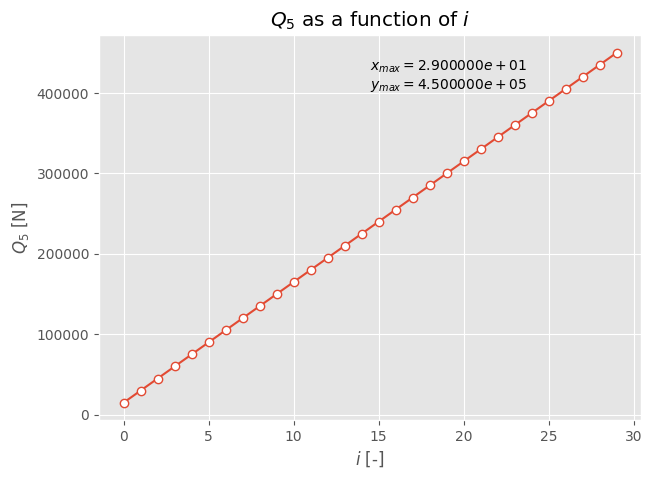

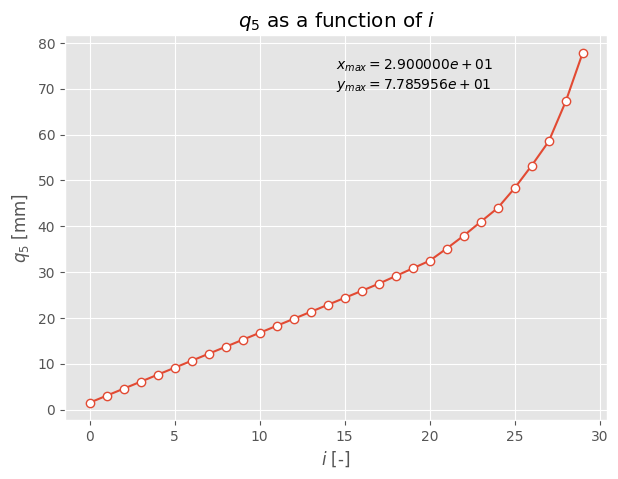

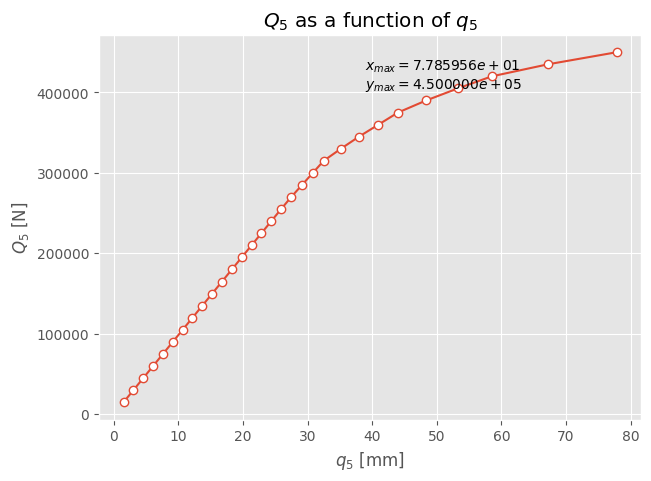

In [53]:
print(force5_step3)
printgraph(iteration_counter,force5_step3,"$i$","$Q_5$","","N")
printgraph(iteration_counter,disp5_step3,"$i$","$q_5$","","mm")
printgraph(disp5_step3,force5_step3,"$q_5$","$Q_5$","mm","N")